In [21]:
import os, sys, math, logging, random
from pathlib import Path

import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import yamlu

from pybpmn.parser import BpmnParser, InvalidBpmnException
from yamlu.img import AnnotatedImage, Annotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
bpmn_paths = yamlu.glob(Path.home() / "ws" / "sapsam" / "sapsam-6k", "*.bpmn")
len(bpmn_paths)

535871

In [23]:
import sys
from tqdm import tqdm
from pybpmn.parser import BpmnParser, InvalidBpmnException
from pybpmn import syntax

logging.getLogger("pybpmn").setLevel("INFO")
parser = BpmnParser(link_pools=False, link_lanes=False)

records = []
for p in tqdm(bpmn_paths):
    try:
        anns = parser.parse_bpmn_anns(p)
        records.append({
            "fname": p.name, 
            "has_error": False,
            "shapes": len([a for a in anns if a.category in set(syntax.BPMNDI_SHAPE_CATEGORIES)]),
            "edges": len([a for a in anns if a.category in set(syntax.BPMNDI_EDGE_CATEGORIES)]),
        })
    except InvalidBpmnException as e:
        records.append({"fname": p.name, "has_error": True, "error_type": e.error_type, "error_details": e.details})
    except Exception as e:
        r = {"fname": p.name, "has_error": True, "error_type": type(e).__name__, "error_details": str(e)}
        print(r)
        records.append(r)

df = pd.DataFrame.from_records(records).set_index("fname")
df[["shapes", "edges"]] = df[["shapes", "edges"]].fillna(-1, downcast="infer")
print(yamlu.bin_stats(df.has_error))

 18%|█▊        | 97415/535871 [58:13<2:00:47, 60.50it/s]   

{'fname': '3265a8c17ef542e492c6bc0ade069027.bpmn', 'has_error': True, 'error_type': 'TypeError', 'error_details': "'NoneType' object is not subscriptable"}


 21%|██        | 109877/535871 [1:02:00<2:12:41, 53.51it/s]

{'fname': '37935a198a0346c38b381636a50b3854.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-DAACD7BC-102A-490A-8206-91B4CEAE606C', 'name': 'Pizza bestellen'} unknown category: conversation"}


 34%|███▎      | 179671/535871 [1:21:32<1:23:38, 70.98it/s]

{'fname': '596f17bf5adf42928cf3a45f8331bc9f.bpmn', 'has_error': True, 'error_type': 'TypeError', 'error_details': "'NoneType' object is not subscriptable"}


 34%|███▍      | 183066/535871 [1:22:21<1:23:29, 70.42it/s]

{'fname': '5aca90a1fcb04990b9b1093132f69f96.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-B9190499-2722-4E09-A94D-332A2B94BF13', 'name': 'Interactiune privind\\n Relatarea/Negocierea \\ncerintelor\\n'} unknown category: conversation"}


 52%|█████▏    | 276557/535871 [1:45:10<59:27, 72.68it/s]  

{'fname': '816bccc707204252a7edabdffba2c2ed.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-4DF81011-3380-4BAF-9822-A4C2A640B389', 'name': 'Pizza bestellen'} unknown category: conversation"}


 74%|███████▍  | 396254/535871 [2:15:38<33:42, 69.04it/s]  

{'fname': 'b7980f3a281d44d496f47f8b61b287a9.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-B2022153-06BE-4F7B-B47D-6BE7FFFA39AF'} unknown category: conversation"}


 84%|████████▍ | 451167/535871 [2:30:00<21:53, 64.51it/s]  

{'fname': 'd320ff3e74304f40ade9cd428a8740b7.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-3B115F0C-A4DC-44B8-8D70-C8FC9695297B', 'name': 'Payment or reservation'} unknown category: conversation"}


 92%|█████████▏| 491778/535871 [2:40:56<10:22, 70.80it/s]

{'fname': 'e966c4d96b364d33b0695a9938049204.bpmn', 'has_error': True, 'error_type': 'AssertionError', 'error_details': "conversation {'id': 'sid-6B0821C4-ECD0-4158-A621-76064D3C0736', 'name': 'Ticket\\nreservation'} unknown category: conversation"}


100%|██████████| 535871/535871 [2:53:29<00:00, 51.48it/s]  


48953/535871 (9.14%)


In [24]:
df.error_type.value_counts()

sequenceFlow has no targetRef attrib                              13969
sequenceFlow has no sourceRef attrib                              13705
messageFlow has no sourceRef attrib                                4991
association has no targetRef attrib                                4806
messageFlow has no targetRef attrib                                4680
association has no sourceRef attrib                                4518
Duplicate model element id                                         1090
Association has another association as src or target                627
Invalid endEvent with multiple event definitions                    215
Invalid intermediateThrowEvent with multiple event definitions      214
Invalid boundaryEvent with multiple event definitions                57
Missing model element                                                44
BPMN Choreography diagrams are not implemented.                      13
sequenceFlow without waypoints                                  

In [25]:
df_no_err = df.query("not has_error").copy()
df_no_err.describe()

,shapes,edges
count,486918.000000,486918.000000
mean,22.092650,21.695688
std,18.228675,19.997346
min,0.000000,0.000000
25%,15.000000,13.000000
50%,20.000000,19.000000
75%,23.000000,25.000000
max,1873.000000,2066.000000


In [26]:
df_no_err.shapes.value_counts().sort_index().head(10)

0    11529
1     1032
2     1764
3     2353
4     4092
5     5868
6     6947
7     8597
8    11388
9    10920
Name: shapes, dtype: int64

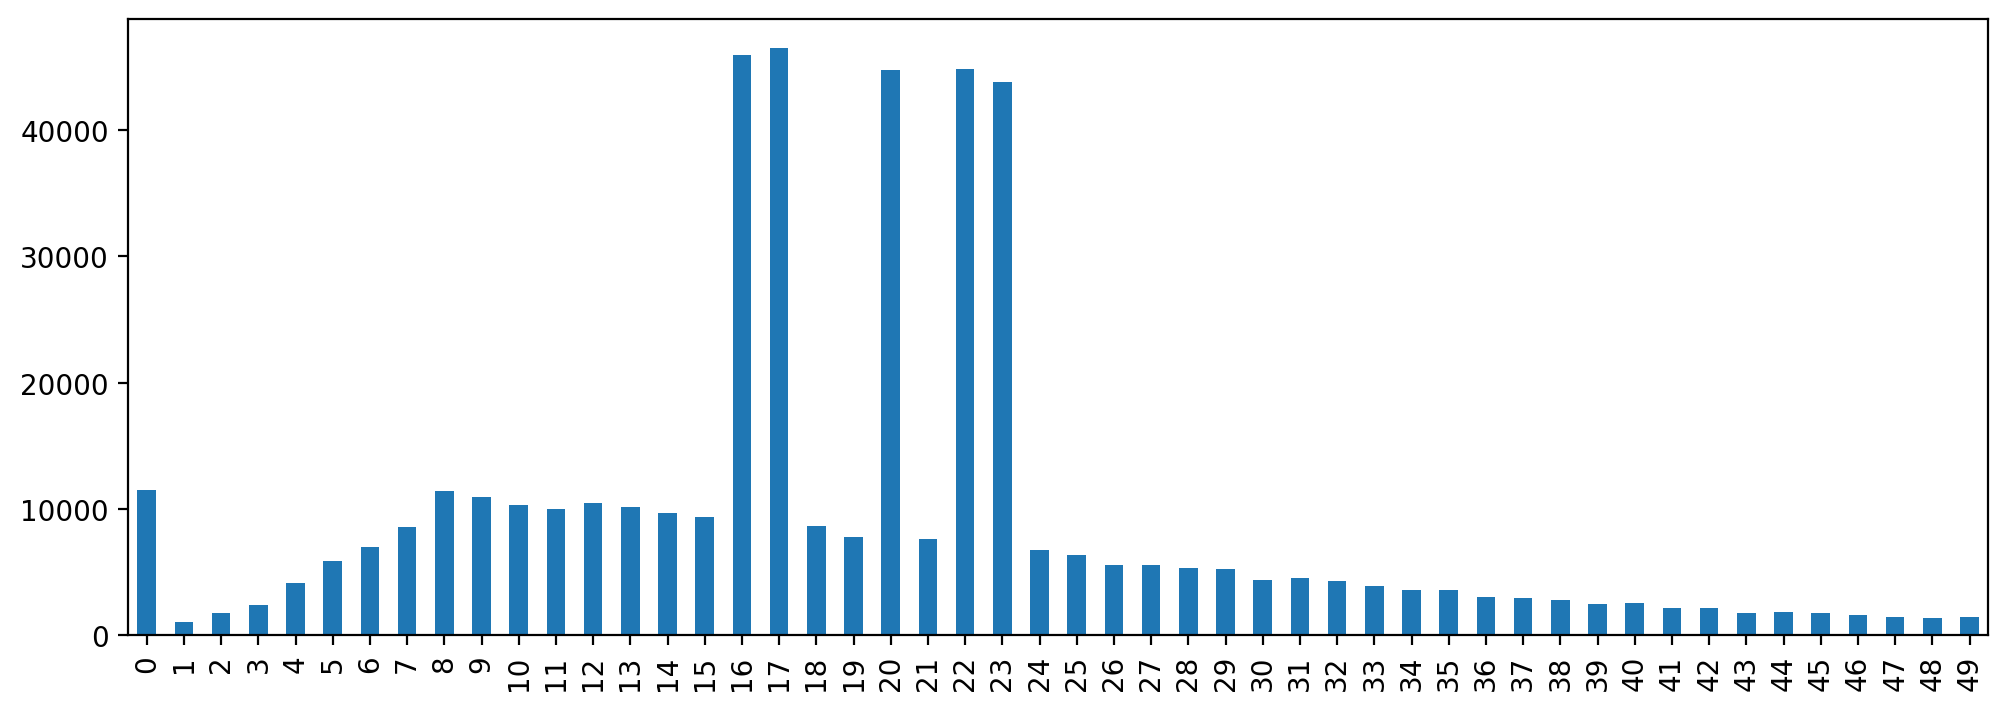

In [27]:
plt.figure(figsize=(12,4))
df_no_err.shapes.value_counts().reindex(np.arange(50)).plot.bar(ax=plt.gca());

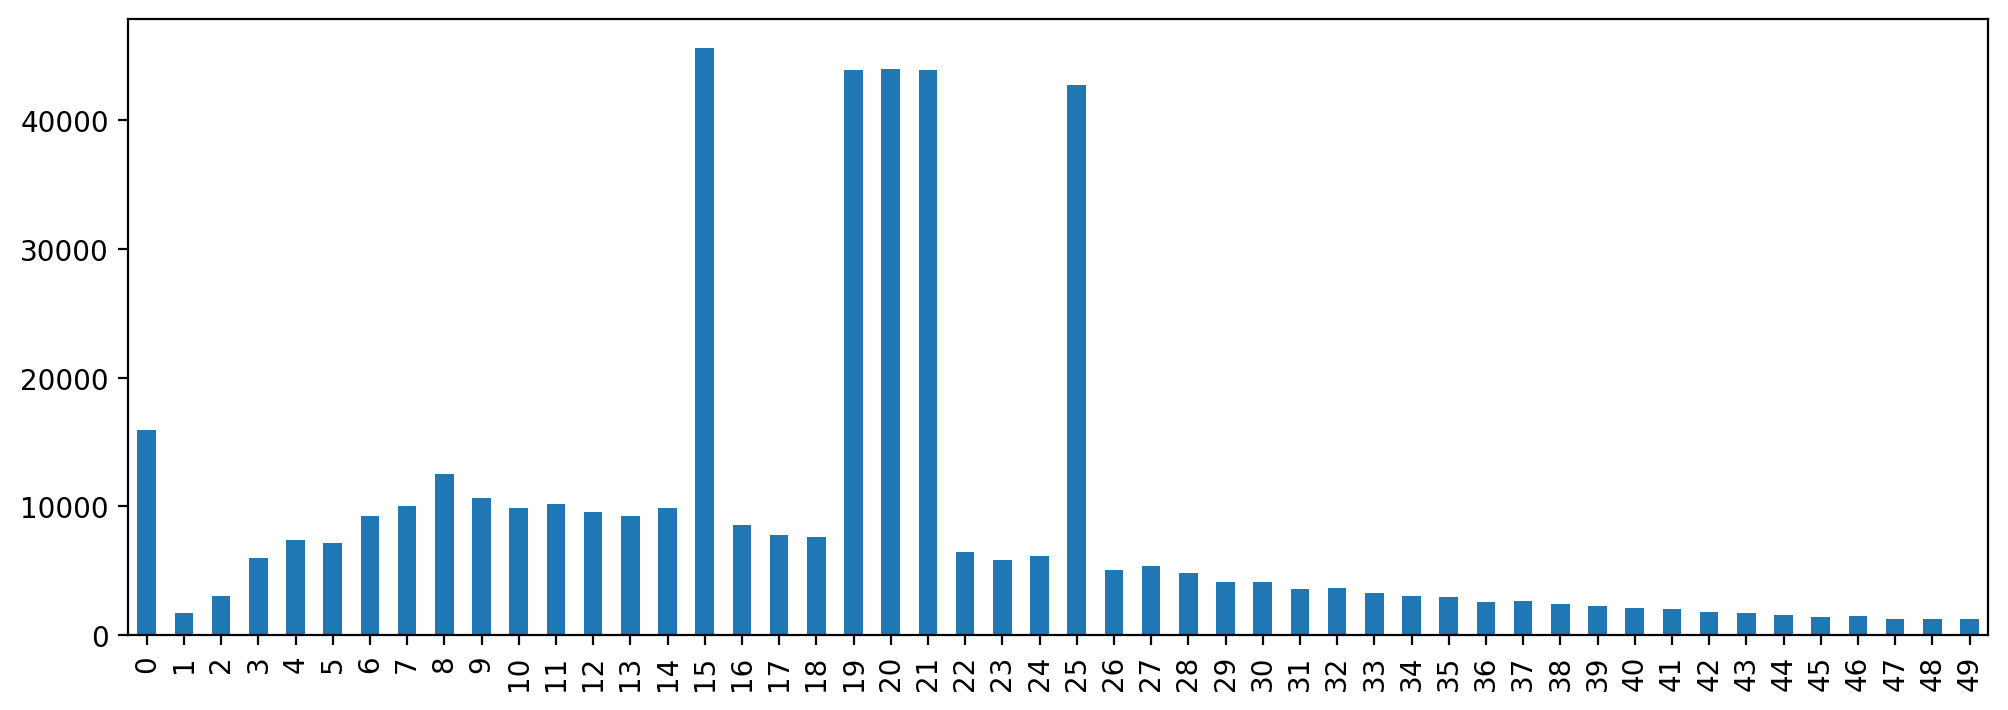

In [28]:
plt.figure(figsize=(12,4))
df_no_err.edges.value_counts().reindex(np.arange(50)).plot.bar(ax=plt.gca());

In [29]:
df_no_err["shapes-edges"] = df_no_err.shapes.map(str) + "-" + df_no_err.edges.map(str)
se_vc = df_no_err["shapes-edges"].value_counts()
se_vc.sort_values(ascending=False).head(20)

23-21    38165
16-15    38093
20-20    37948
17-19    37903
22-25    37544
0-0      11529
8-8       4132
5-4       3467
4-3       3041
6-5       2559
9-9       2422
8-7       2334
7-7       2223
7-6       2110
9-8       2056
10-10     1972
7-4       1903
6-6       1818
14-11     1801
11-11     1799
Name: shapes-edges, dtype: int64

In [30]:
cutoff = len(df_no_err) / 50
print(cutoff)
outliers = se_vc[se_vc > cutoff].index.tolist()
if "0-0" not in outliers:
    outliers.append("0-0")
outliers

9738.36


['23-21', '16-15', '20-20', '17-19', '22-25', '0-0']

In [31]:
mask = ~df_no_err["shapes-edges"].isin(outliers)
df_no_err.loc[mask].reset_index()["fname"].to_csv("fnames.csv", index=False, header=False)
print(mask)

fname
0000150e890c45928d26584d491ada68.bpmn     True
00001f477e9a4fb1b9dcb27e029a426d.bpmn    False
00003a67300748639e4bc21398bb5ede.bpmn     True
00005cea16fd426881c7f1619e30b804.bpmn     True
0000c3ea6c58407dbfaeac9ef5e467e7.bpmn    False
                                         ...  
ffffc29ea95142e185189e9d35a51ad2.bpmn     True
ffffcd5186bf4655b510ec28d21f0dc3.bpmn     True
ffffe3bf630542ef846c139be1af7469.bpmn     True
fffff2b0eafa4ecca0b00fb5c6ccb4ef.bpmn    False
ffffffd24864440a8effa3cdb9d37cce.bpmn     True
Name: shapes-edges, Length: 486918, dtype: bool
